In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read the dataset

In [2]:
x_train = pd.read_csv('/content/drive/MyDrive/Project/Student-performance-UCI/Datasets/x_train_clean_11.csv')
x_test = pd.read_csv('/content/drive/MyDrive/Project/Student-performance-UCI/Datasets/x_test_clean_11.csv')
y_train = pd.read_csv('/content/drive/MyDrive/Project/Student-performance-UCI/Datasets/y_train.csv')
y_test = pd.read_csv('/content/drive/MyDrive/Project/Student-performance-UCI/Datasets/y_test.csv')

In [3]:
y_test1 = y_test["G3"]
y_train1 = y_train["G3"]

In [4]:
!pip install --upgrade scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import shap

In [7]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Getter function for adjusted R-squared

In [8]:
def adj_r2_score(y_true, y_pred, n_features):
    r2 = r2_score(y_true, y_pred)
    adj_r2 = 1 - (1 - r2) * (len(y_true) - 1) / (len(y_true) - n_features - 1)
    return adj_r2

## 1) Random Forest Baseline

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
print("--------Random Forest_CV--------")
# Create a Random Forest regressor
rf_regressor = RandomForestRegressor(random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(rf_regressor, x_train, y_train1,
                            cv=5, scoring='neg_mean_squared_error')

# Convert the negative MSE scores to positive RMSE scores
cv_rmse_scores = np.sqrt(-cv_scores)

adj_r2_scores = cross_val_score(rf_regressor, x_train, y_train1,
                                cv=5, scoring='r2')
# Multiply the scores by -1 to obtain positive R-squared values
positive_r2_scores = -adj_r2_scores

# Calculate the mean and standard deviation of the RMSE scores
mean_rmse = np.mean(cv_rmse_scores)
std_rmse = np.std(cv_rmse_scores)

# Calculate the mean and standard deviation of the R-squared scores
mean_r2 = np.mean(positive_r2_scores)
std_r2 = np.std(positive_r2_scores)

print("CV RMSE scores:", cv_rmse_scores)
print("Mean RMSE:", mean_rmse)
print("Std RMSE:", std_rmse)

print("CV R^2 scores:", -positive_r2_scores)
print("Mean R^2:", -mean_r2)
print("Std R^2:", std_r2)

--------Random Forest_CV--------
CV RMSE scores: [1.83020103 1.54838125 1.54623072 1.0187647  1.71507602]
Mean RMSE: 1.531730744661942
Std RMSE: 0.2779646227292813
CV R^2 scores: [0.79104477 0.80878039 0.8213908  0.92390656 0.83520499]
Mean R^2: 0.836065502891364
Std R^2: 0.04626766182059448


In [11]:
print("--------RF--------")
# create and fit the model
start_time = time.time()
rf_reg = RandomForestRegressor(random_state=42)
end_time = time.time()
rf_reg.fit(x_train, y_train1)

# predict on the test set
y_pred = rf_reg.predict(x_test)

# evaluate the model using mean squared error
mse = mean_squared_error(y_test1, y_pred)

# calculate adjusted R^2
adj_r2 = adj_r2_score(y_test, y_pred, x_test.shape[1])
print('Training time: {:.5} seconds'.format(end_time - start_time))
print("Mean Squared Error:", mse)
print('Adjusted R^2:', adj_r2)

--------RF--------
Training time: 0.000144 seconds
Mean Squared Error: 2.4030837668082095
Adjusted R^2: 0.8321279964876281


Feature Importance for the Random Forest

                 Feature  Importance
9   G1_G2_sum_normalized    0.835474
10   absences_normalized    0.067098
0                    age    0.020566
4                   Mjob    0.017603
3                   Fedu    0.012147
2                   Medu    0.012099
5              studytime    0.011723
8                subject    0.008204
6               failures    0.006695
1                address    0.004762


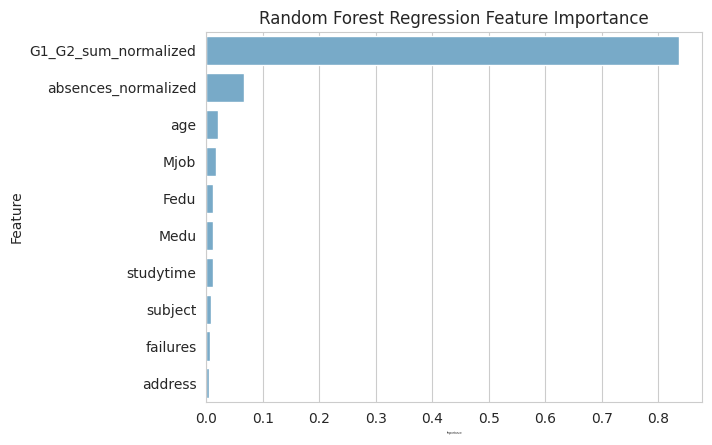

In [12]:
# import the color palette from Seaborn
from matplotlib import cm

# define the color
color = cm.Blues(0.5)

# get feature importances
importances = rf_reg.feature_importances_

# create a dataframe to store the feature importances
feature_importances = pd.DataFrame({'Feature': x_train.columns,
                                    'Importance': importances})

# sort the features by importance score
feature_importances = feature_importances.sort_values(by='Importance',
                                                      ascending=False)

# display the top 10 features by importance score
print(feature_importances.head(10))

# plot the feature importances using Seaborn
sns.set_style('whitegrid')
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10), color=color)
plt.title('Random Forest Regression Feature Importance')
plt.xlabel('Importance', fontsize=2)
plt.show()

Shaply plot for the Random Forest

Permutation explainer: 101it [01:13,  1.36it/s]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


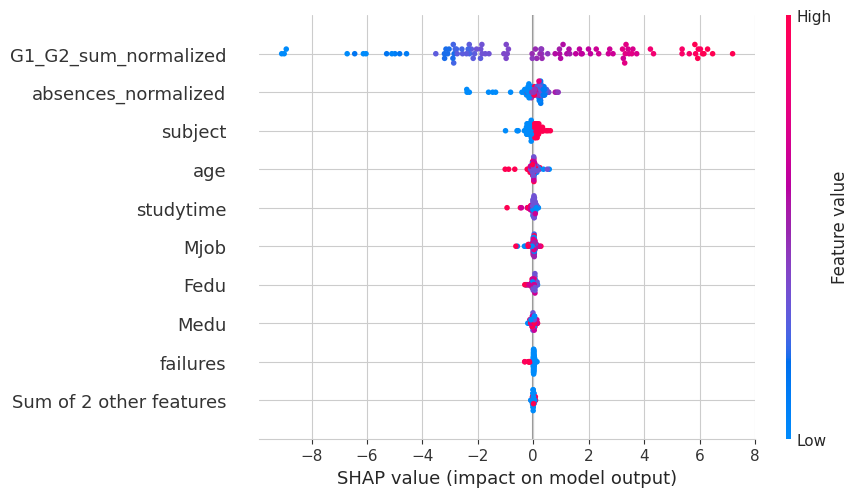

In [13]:
# sample 200 rows from x_test_hybrid randomly
sample_indices = np.random.choice(x_test.shape[0], size=100, replace=False)
x_test_sample = x_test.iloc[sample_indices]

explainer = shap.Explainer(rf_reg.predict, x_test_sample)

sv = explainer(x_test_sample)
shap.plots.beeswarm(sv)

## 2) LGBM

In [14]:
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
print("--------LGBM_CV--------")
# Define a custom scoring function to calculate adjusted R-squared
def adj_r2_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    adj_r2 = adj_r2_score(y, y_pred, X.shape[1])
    return adj_r2

# Create a LightGBM regressor
lgb_regressor = lgb.LGBMRegressor(random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(lgb_regressor, x_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Convert the negative MSE scores to positive RMSE scores
cv_rmse_scores = np.sqrt(-cv_scores)

adj_r2_scores = cross_val_score(lgb_regressor, x_train, y_train, cv=5, scoring='r2')
# Multiply the scores by -1 to obtain positive R-squared values
positive_r2_scores = -adj_r2_scores

# Calculate the mean and standard deviation of the RMSE scores
mean_rmse = np.mean(cv_rmse_scores)
std_rmse = np.std(cv_rmse_scores)

# Calculate the mean and standard deviation of the R-squared scores
mean_r2 = np.mean(positive_r2_scores)
std_r2 = np.std(positive_r2_scores)

print("CV RMSE scores:", cv_rmse_scores)
print("Mean RMSE:", mean_rmse)
print("Std RMSE:", std_rmse)

print("CV R^2 scores:", -positive_r2_scores)
print("Mean R^2:", -mean_r2)
print("Std R^2:", std_r2)

--------LGBM_CV--------
CV RMSE scores: [1.829137   1.47888143 1.44468775 1.06583808 1.55442104]
Mean RMSE: 1.4745930579452842
Std RMSE: 0.24497643423530824
CV R^2 scores: [0.79128766 0.8255611  0.8440795  0.9167121  0.86463243]
Mean R^2: 0.8484545606394278
Std R^2: 0.041790241031542434


In [15]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   730 non-null    int64  
 1   address               730 non-null    int64  
 2   Medu                  730 non-null    int64  
 3   Fedu                  730 non-null    int64  
 4   Mjob                  730 non-null    int64  
 5   studytime             730 non-null    int64  
 6   failures              730 non-null    int64  
 7   higher                730 non-null    int64  
 8   subject               730 non-null    int64  
 9   G1_G2_sum_normalized  730 non-null    float64
 10  absences_normalized   730 non-null    float64
dtypes: float64(2), int64(9)
memory usage: 62.9 KB


In [16]:
print("--------LGBM--------")
import lightgbm as lgb
# Create a LightGBM regressor
lgb_regressor = lgb.LGBMRegressor(random_state = 42)
cat_features_index = [1,2,3,4,5,6,7,8]
# Train the regressor
start_time = time.time()
lgb_regressor.fit(x_train, y_train,categorical_feature=cat_features_index)
end_time = time.time()
# Make predictions on the test data
y_pred1 = lgb_regressor.predict(x_test)

# Calculate the RMSE
mse = mean_squared_error(y_test1, y_pred1)

# Calculate the R^2
r2 = r2_score(y_test1, y_pred1)

# calculate adjusted R^2
adj_r2 = adj_r2_score(y_test1, y_pred1, x_test.shape[1])
print('Training time: {:.5} seconds'.format(end_time - start_time))
print("Mean Squared Error:", mse)
print('Adjusted R^2:', adj_r2)

--------LGBM--------
Training time: 0.047168 seconds
Mean Squared Error: 2.330250696858614
Adjusted R^2: 0.8372158896119842


Using categorical_feature in Dataset.


Feature Importance for LGBM

                 Feature  Importance
9   G1_G2_sum_normalized         982
10   absences_normalized         719
0                    age         398
8                subject         181
1                address         106
4                   Mjob          52
3                   Fedu          47
2                   Medu          39
6               failures          27
7                 higher          25


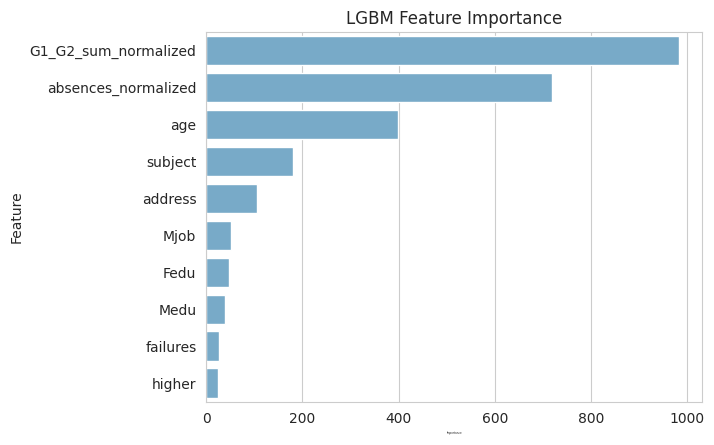

In [17]:
# import the color palette from Seaborn
from matplotlib import cm

# define the color
color = cm.Blues(0.5)

# get feature importances
importances = lgb_regressor.feature_importances_

# create a dataframe to store the feature importances
feature_importances = pd.DataFrame({'Feature': x_train.columns,
                                    'Importance': importances})

# sort the features by importance score
feature_importances = feature_importances.sort_values(by='Importance',
                                                      ascending=False)

# display the top 10 features by importance score
print(feature_importances.head(10))

# plot the feature importances using Seaborn
sns.set_style('whitegrid')
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10), color=color)
plt.title('LGBM Feature Importance')
plt.xlabel('Importance', fontsize=2)
plt.show()

Shaply Plot for LGBM

Permutation explainer: 101it [00:34,  1.95it/s]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


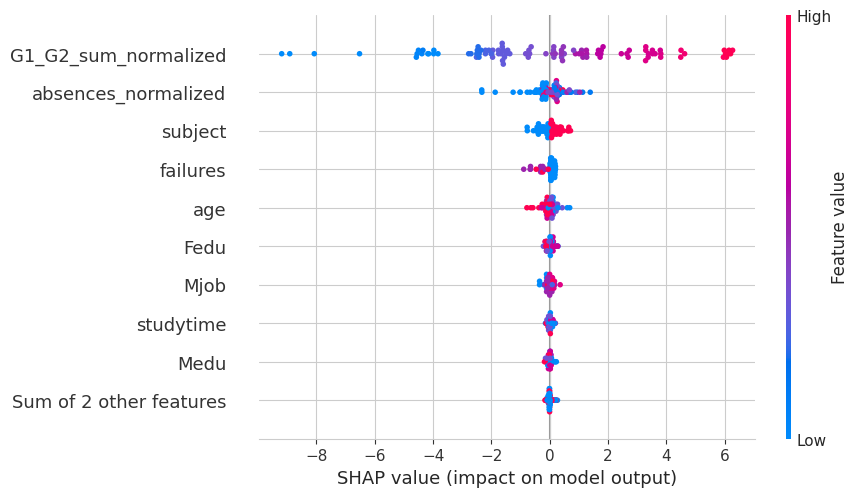

In [18]:
# sample 200 rows from x_test_hybrid randomly
sample_indices = np.random.choice(x_test.shape[0], size=100, replace=False)
x_test_sample = x_test.iloc[sample_indices]

explainer = shap.Explainer(lgb_regressor.predict, x_test_sample)

sv = explainer(x_test_sample)
shap.plots.beeswarm(sv)

## 3) XGBOOST

In [19]:
import xgboost as xgb
print("--------XGBoost_CV--------")

# Create an XGBoost regressor
xgb_regressor = xgb.XGBRegressor(random_state=42, verbosity=0)

# Perform cross-validation
cv_scores = cross_val_score(xgb_regressor, x_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Convert the negative MSE scores to positive RMSE scores
cv_rmse_scores = np.sqrt(-cv_scores)

adj_r2_scores = cross_val_score(xgb_regressor, x_train, y_train, cv=5, scoring='r2')
# Multiply the scores by -1 to obtain positive R-squared values
positive_r2_scores = -adj_r2_scores

# Calculate the mean and standard deviation of the RMSE scores
mean_rmse = np.mean(cv_rmse_scores)
std_rmse = np.std(cv_rmse_scores)

# Calculate the mean and standard deviation of the R-squared scores
mean_r2 = np.mean(positive_r2_scores)
std_r2 = np.std(positive_r2_scores)

print("CV RMSE scores:", cv_rmse_scores)
print("Mean RMSE:", mean_rmse)
print("Std RMSE:", std_rmse)

print("CV R^2 scores:", -positive_r2_scores)
print("Mean R^2:", -mean_r2)
print("Std R^2:", std_r2)

--------XGBoost_CV--------
CV RMSE scores: [2.03123881 1.6049965  1.63336609 1.3305053  1.85899913]
Mean RMSE: 1.6918211638244522
Std RMSE: 0.23860321860334166
CV R^2 scores: [0.74261833 0.79454117 0.80069312 0.87021257 0.80638648]
Mean R^2: 0.8028903330879527
Std R^2: 0.04062451693535624


In [20]:
import xgboost as xgb
print("--------XGBoost--------")
# Instantiate an XGBoost regressor
xgb_reg = xgb.XGBRegressor(random_state = 42)
start_time = time.time()
# Train the model on the training data
xgb_reg.fit(x_train, y_train)
end_time = time.time()
# Predict the target values for the test data
y_pred2 = xgb_reg.predict(x_test)

# Calculate the RMSE
mse = mean_squared_error(y_test1, y_pred2)
# calculate adjusted R^2
adj_r2 = adj_r2_score(y_test1, y_pred2, x_test.shape[1])
print('Training time: {:.5} seconds'.format(end_time - start_time))
print("Mean Squared Error:", mse)
print('Adjusted R^2:', adj_r2)

--------XGBoost--------
Training time: 0.10479 seconds
Mean Squared Error: 2.755359656115099
Adjusted R^2: 0.8075190918194415


Feature Importance for XGBoost

                 Feature  Importance
9   G1_G2_sum_normalized    0.677350
10   absences_normalized    0.076813
7                 higher    0.047481
0                    age    0.041287
5              studytime    0.030156
4                   Mjob    0.028008
8                subject    0.024550
3                   Fedu    0.024275
1                address    0.017168
6               failures    0.016743


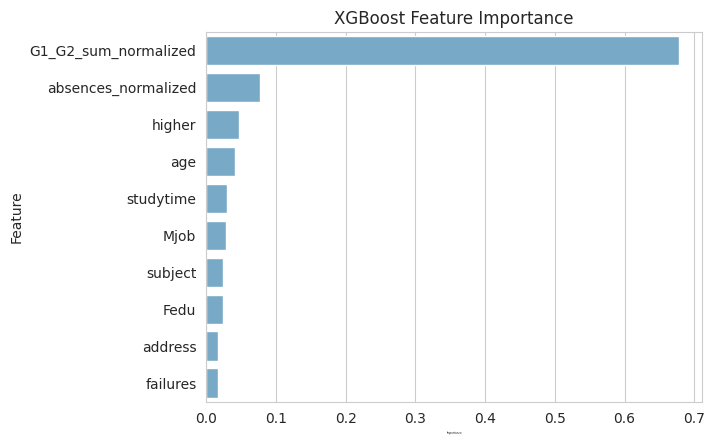

In [21]:
# import the color palette from Seaborn
from matplotlib import cm

# define the color
color = cm.Blues(0.5)

# get feature importances
importances = xgb_reg.feature_importances_

# create a dataframe to store the feature importances
feature_importances = pd.DataFrame({'Feature': x_train.columns,
                                    'Importance': importances})

# sort the features by importance score
feature_importances = feature_importances.sort_values(by='Importance',
                                                      ascending=False)

# display the top 10 features by importance score
print(feature_importances.head(10))

# plot the feature importances using Seaborn
sns.set_style('whitegrid')
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10), color=color)
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance', fontsize=2)
plt.show()

Shaply plot for XGBoost

Permutation explainer: 101it [00:17,  2.44it/s]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


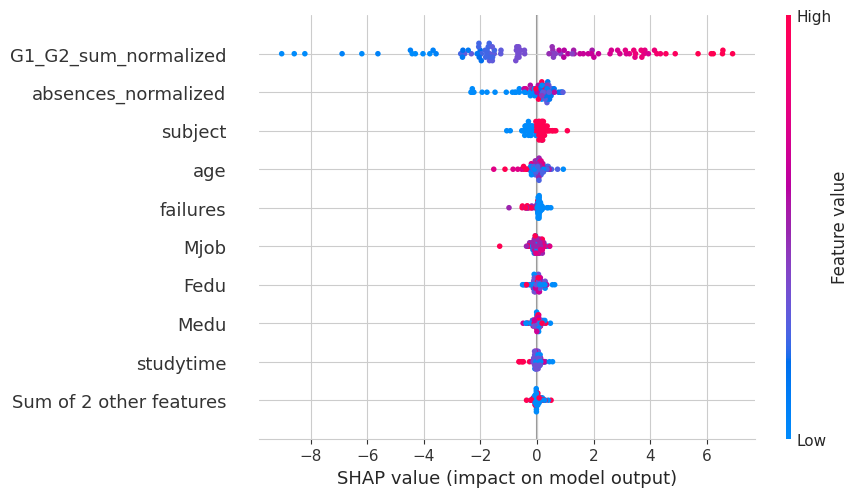

In [22]:
# sample 200 rows from x_test_hybrid randomly
sample_indices = np.random.choice(x_test.shape[0], size=100, replace=False)
x_test_sample = x_test.iloc[sample_indices]

explainer = shap.Explainer(xgb_reg.predict, x_test_sample)

sv = explainer(x_test_sample)
shap.plots.beeswarm(sv)

## 4) Catboost

In [23]:
from catboost import CatBoostRegressor
print("--------CatBoost_CV--------")
# Create a CatBoost regressor
catboost_regressor = CatBoostRegressor(random_state=42, verbose=False)

# Perform cross-validation
cv_scores = cross_val_score(catboost_regressor, x_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Convert the negative MSE scores to positive RMSE scores
cv_rmse_scores = np.sqrt(-cv_scores)

adj_r2_scores = cross_val_score(catboost_regressor, x_train, y_train, cv=5, scoring='r2')
# Multiply the scores by -1 to obtain positive R-squared values
positive_r2_scores = -adj_r2_scores

# Calculate the mean and standard deviation of the RMSE scores
mean_rmse = np.mean(cv_rmse_scores)
std_rmse = np.std(cv_rmse_scores)

# Calculate the mean and standard deviation of the R-squared scores
mean_r2 = np.mean(positive_r2_scores)
std_r2 = np.std(positive_r2_scores)

print("CV RMSE scores:", cv_rmse_scores)
print("Mean RMSE:", mean_rmse)
print("Std RMSE:", std_rmse)

print("CV R^2 scores:", -positive_r2_scores)
print("Mean R^2:", -mean_r2)
print("Std R^2:", std_r2)

--------CatBoost_CV--------
CV RMSE scores: [1.89226379 1.52492703 1.59861295 1.1067565  1.60599554]
Mean RMSE: 1.5457111618100265
Std RMSE: 0.2528417310211726
CV R^2 scores: [0.776633   0.81452954 0.80908419 0.91019436 0.85550062]
Mean R^2: 0.8331883450220705
Std R^2: 0.045946561242077105


In [24]:
print("--------CatBoost--------")

# Initialize the CatBoostRegressor model
cat_reg = CatBoostRegressor(random_seed=42, loss_function='RMSE')

# Fit the model on the training data
cat_reg.fit(x_train, y_train1, verbose = False)

# Predict on the validation data
y_pred4 = cat_reg.predict(x_test)

# Calculate the RMSE
mse = mean_squared_error(y_test1, y_pred4)
# calculate adjusted R^2
adj_r2 = adj_r2_score(y_test1, y_pred4, x_test.shape[1])

print("Mean Squared Error:", mse)
print('Adjusted R^2:', adj_r2)

--------CatBoost--------
Mean Squared Error: 2.5384220921452982
Adjusted R^2: 0.8226736794387794


Feature importance for CatBoost

                 Feature  Importance
9   G1_G2_sum_normalized   65.427170
10   absences_normalized   11.683190
0                    age    4.062246
8                subject    3.778650
4                   Mjob    3.038185
2                   Medu    2.807048
3                   Fedu    2.530952
5              studytime    2.397324
6               failures    2.348195
1                address    1.090673


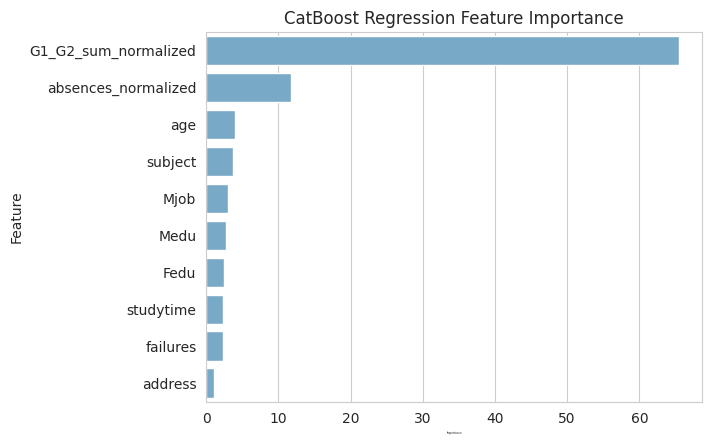

In [25]:
# import the color palette from Seaborn
from matplotlib import cm

# define the color
color = cm.Blues(0.5)

# get feature importances
importances = cat_reg.feature_importances_

# create a dataframe to store the feature importances
feature_importances = pd.DataFrame({'Feature': x_train.columns,
                                    'Importance': importances})

# sort the features by importance score
feature_importances = feature_importances.sort_values(by='Importance',
                                                      ascending=False)

# display the top 10 features by importance score
print(feature_importances.head(10))

# plot the feature importances using Seaborn
sns.set_style('whitegrid')
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(10), color=color)
plt.title('CatBoost Regression Feature Importance')
plt.xlabel('Importance', fontsize=2)
plt.show()

Shaply Plot

In [ ]:
# sample 200 rows from x_test_hybrid randomly
sample_indices = np.random.choice(x_test.shape[0], size=100, replace=False)
x_test_sample = x_test.iloc[sample_indices]

explainer = shap.Explainer(cat_reg.predict, x_test_sample)

sv = explainer(x_test_sample)
shap.plots.beeswarm(sv)

## 5) Conclusion

**Observations**
* LGBM regressor is the best model to model the scores of the students.
* The students G1 and G2 scores are indicators of final G3 performance.
* Even though Students' absentism has a relatively high feature importance, students with low absentism scores fall on both sides of the spectrum based on the shaply plot above.
* Antecedent `failures`, `age`, `Mjob` and `subject` variables show clear effect on the students' scores.

**Insights and possible Actions**
1. From the `failures` column, students with higher failures are predicted to score worse in G3 scores. We postulate that the failures imply that the students do not master the foundations of the subjects sufficiently and this has a cascading effect on the higher level subjects which are built on the foundations of the lower level subjects. Therefore, it is important to provide refresher or remedial classes before the start of higher level to ensure that these students with high failure rates are up to mark with the rigour of the subjects. 

2. Older students get higher score from the `age` column in the Shaply plot. We postulate that the brain development and maturity play signficant roles on the student focus on the academics.

3. From the `subject` column, we could see that the students struggle much more with portuguese compared to math(0 is math and 1 is portuguese). Teaching methodology should be reviewed to ensure students master portuguese better and obtain higher score.

4. From the `Mjob` column, it has higher feature importance from the 4 models above. However, the Shaply plot does not clear distinct effect of each category on the output. Hence, more research is needed to crystallise the effect of category on the students' scores.